In [1]:
!pip install category_encoders
!pip install joblib

## Import the needed libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import get_cmap
from category_encoders import TargetEncoder
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import requests
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
from kafka import KafkaConsumer

## Function to use target encoder  

In [3]:
def target_encode(df, column, is_training_data = True):

  encoder = TargetEncoder(cols=[column])
    
  if is_training_data:
    encoder.fit(df, df['Target Attack'])
    
  df = encoder.transform(df)

  return df

## Function that get 1000 sample from the data as a dataframe

In [4]:
def kafka_consumer(max_iterations=1000):

    data = {col: [] for col in col_names}
    
    for iteration in range(max_iterations):
        msg = next(consumer)

        message = msg.value.decode('utf-8')
        message_values = message.strip().split(',')

        for col, value in zip(col_names, message_values):
            data[col].append(value)
            
    df = pd.DataFrame(data)
    df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: int(x.replace('\\n', '').strip('"\n')))

    return df

## Function to retrain the dynamic model in case of a condition

In [7]:
def retrain(df, total_df, precision_d, dynamic_model):
    
    print("********************************************************************************************")

    print("Precision value is less than 0.75. Retraining the model over the old data ....\n")

    total_df = pd.concat([total_df, df], ignore_index=True)

    if total_df.shape[0] > 10000:
        print("Samples is more than 10,000\n")

        X_train, X_test, Y_train, Y_test = train_test_split(
            total_df.iloc[:, :-1],
            total_df.iloc[:, -1],
            train_size=5000,
            random_state=42,
            stratify=total_df.iloc[:, -1]
        )
        
        print(f"Trained over {X_train.shape[0]} samples\n")
        print("********************************************************************************************\n\n")

        
        dynamic_model.fit(X_train, Y_train)
        
        with open('Best_dynamic_model.pkl', 'wb') as model_file:
            pickle.dump(dynamic_model, model_file)
            
    else:
        
        print(f"Train over {total_df.shape[0]} samples\n")
        print("********************************************************************************************\n\n")

        dynamic_model.fit(total_df.iloc[:, :-1], total_df.iloc[:, -1])
        with open('Best_dynamic_model.pkl', 'wb') as model_file:
            pickle.dump(dynamic_model, model_file)
    
    return total_df, dynamic_model

## Function to calculate the precision of static and dynamic models with no conditions

In [8]:
def evaluate_models(dynamic_model , static_model, scaler):
        
        df = kafka_consumer()    
        
        df = df.iloc[:, [1, 2, 3, 4, 5, 7, 8, 11, 14, 15]]
        df = target_encode(df, "longest_word")
        
        X = df.iloc[:,:-1]
        Y = df.iloc[:,-1]

        X = scaler.transform(X)
        X = pd.DataFrame(X)
        
        y_pred_d = dynamic_model.predict(X)
        y_pred_s = static_model.predict(X)

        precision_d = precision_score(Y, y_pred_d)
        precision_s = precision_score(Y, y_pred_s)

        print(f"Precision of the dynamic model : : {precision_d}\n")
        print(f"Precision of the static model : : {precision_s}\n")
        print("----------------------------------\n\n")
        
        df = pd.concat([X, Y], axis=1)
        
        return df, precision_d, precision_s, dynamic_model

## Function to combine the previous functions and displa the line plot for the precisions of static and dyanamic models 

In [9]:
def evaluate_dynamic_model():
    
    static_model = dynamic_model =  pickle.load(open('Best_model.pkl', 'rb'))
    scaler = joblib.load('Scaler.pkl')

    total_df = pd.DataFrame()
    static_l, dynamic_l = [], []
    
    for i in range(1,268):

        print(f"Window {i} : \n")
        print("_________________\n\n")
        df, precision_d, precision_s, dynamic_model = evaluate_models(dynamic_model, static_model, scaler)
        
        static_l.append(precision_s)
        dynamic_l.append(precision_d)
        
        if precision_d < 0.75:
            
            total_df, dynamic_model = retrain(df, total_df, precision_d, dynamic_model)
            dynamic_model =  pickle.load(open('Best_dynamic_model.pkl', 'rb'))

        
    windows = list(range(1, 268))
    
    plt.figure(figsize=(12, 8))    
    
    plt.plot(windows, static_l, label='Static Model', marker='*')
    plt.plot(windows, dynamic_l, label='Dynamic Model', marker='.')

    plt.xlabel('Window Number')
    plt.ylabel('Precision Score')
    plt.title('Precision Scores for Static and Dynamic Models over Windows')

    plt.legend()
    plt.show()   

In [5]:
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]


In [6]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)


Window 1 : 

_________________


Precision of the dynamic model : : 0.7479338842975206

Precision of the static model : : 0.7479338842975206

----------------------------------


********************************************************************************************
Precision value is less than 0.75. Retraining the model over the old data ....

Train over 1000 samples

********************************************************************************************


Window 2 : 

_________________


Precision of the dynamic model : : 0.7265415549597856

Precision of the static model : : 0.7265415549597856

----------------------------------


********************************************************************************************
Precision value is less than 0.75. Retraining the model over the old data ....

Train over 2000 samples

********************************************************************************************


Window 3 : 

_________________


Precision of the dynami

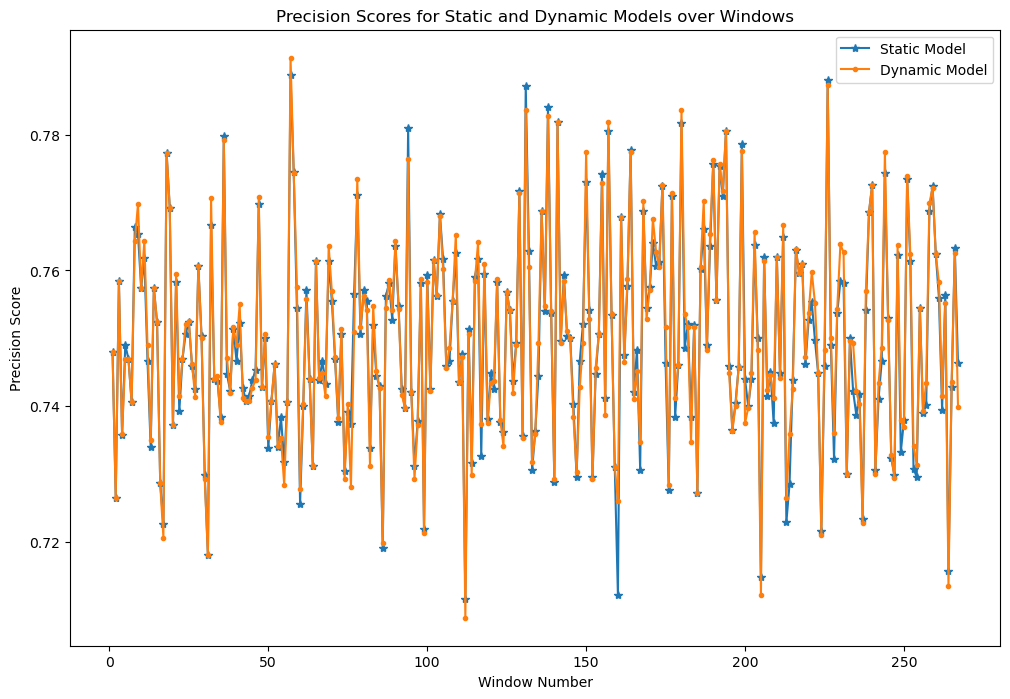

In [11]:
evaluate_dynamic_model()